In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.stats.proportion import proportion_confint

In [2]:
PATH_TO_EXPS = 'user_identification_exps'

In [53]:
def count_users(data, feature, xlabel, ticks_delta=1, xticks=None, xlims=None, seab=False):
    '''Функция, которая строит'''
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 12))
    axes = axes.ravel()
    palette = sns.color_palette('Dark2') + sns.color_palette('Accent_r')
    for idx, (user, sub_df) in  enumerate(data.groupby('user_id')):
        if xlims!=None:
            x_min, x_max = xlims
        else:
            x_max = data[feature].max()
            x_min = data[feature].min()
        if seab:
            sns.countplot(ax=axes[idx], x=feature, data=sub_df, color=palette[idx], label='user_'+str(user))
        else:
            sub_df[feature].hist(ax=axes[idx], color=palette[idx], label='user_'+str(user), 
                               bins=np.arange(x_max+2)-0.5)
        axes[idx].set_xlim([x_min-1, x_max+1])
        axes[idx].set_xticks(np.arange(x_min, x_max+1, ticks_delta))
        axes[idx].legend(loc='upper left')
        axes[idx].set_xlabel(xlabel)
        axes[idx].set_ylabel('Кол-во сессий')
        if xticks!=None:
            axes[idx].set_xticklabels(xticks)
    for i in range(idx+1, axes.shape[0]):
        axes[i].remove()
    plt.show()

In [10]:
def woe_encoder(data, feature, max_lim, fill_method=None):
    '''Функция, которая кодирует вещественный признак в n признаков, где n - кол-во классов. 
    Признаки строятся как log(p(1)/p(0)).
    Значения признаков больше max_lim заполняются в зависимости от fill_method:
        zero - нулями;
        random - равномерным распределением из диапазона значений итогового признака;
        otlier - большим отрицательным числом (-20);
        pass - не заполняется ничем.'''
    data = data.copy()
    if fill_method not in ('zero', 'random', 'outlier', 'pass'):
        raise ValueError ('Specify fill_method')
    woe_dicts = []
    for user_id in set(data.user_id):
        df_tmp = data[[feature, 'user_id']]
        df_tmp = df_tmp[df_tmp[feature]<max_lim]
        df_tmp.user_id = df_tmp.user_id.apply(lambda x: 1 if x==user_id else 0)
        df_tmp[feature] = pd.cut(df_tmp[feature], bins=25)
        df_grouped = df_tmp.groupby([feature, 'user_id']).size()
        p_0 = df_grouped.loc[df_grouped.index.get_level_values('user_id')==0]
        p_0 = p_0/p_0.sum()
        p_1 = df_grouped.loc[df_grouped.index.get_level_values('user_id')==1]
        p_1 = p_1/p_1.sum()
        woe_dict = pd.Series(np.log(0.00001 + p_1.values/p_0.values))
        woe_dict.index = p_0.index.get_level_values(feature)
        data['woe_user'+str(user_id)+'_'+feature] = pd.to_numeric(df_tmp[feature].map(woe_dict))
        if fill_method=='zero':
            data = data.fillna(value={'woe_user'+str(user_id)+'_'+feature: 0})
        if fill_method=='random':
            column = data['woe_user'+str(user_id)+'_'+feature]
            column[column.isna()] = np.random.uniform(column.min(), column.max(), column.isna().sum())
        if fill_method=='outlier':
            data = data.fillna(value={'woe_user'+str(user_id)+'_'+feature: -20})
            # тк минимальный значением любого такого признака будет np.log(0.00001)=-11.5
        woe_dicts.append(woe_dict)
    return data, woe_dicts

## Признаки по 10 пользователям для соревнования Catch Me

In [11]:
data_10users = pd.read_csv(os.path.join(PATH_TO_EXPS, 'train_data_10users_for_catch_me.csv'), index_col=0)

In [12]:
features_10users = pd.read_csv(os.path.join(PATH_TO_EXPS, 'new_features_10users_for_catch_me.csv'), index_col=0)

In [13]:
data_10users.shape

(14645, 27)

In [9]:
data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,diff_time8,diff_time9,diff_time10,start_hour,day_of_week,year,month,day,time_of_day,user_id
session_id,,,,,,,,,,,,,,,,,,,,,
1,192,574,133,3,133,133,3,133,203,133,...,1,0,0,8,4,2013,11,15,0,31
2,415,193,674,254,133,31,393,3305,217,55,...,3,8,1,8,4,2013,11,15,0,31
3,55,3,55,55,5,293,415,333,897,55,...,0,0,0,8,4,2013,11,15,0,31
4,473,3306,473,55,55,55,55,937,199,123,...,0,0,0,8,4,2013,11,15,0,31
5,342,55,5,3307,258,211,3308,2086,675,2086,...,1,0,1,8,4,2013,11,15,0,31


In [11]:
features_10users.head()

,session_timespan,unique_sites,top_sites_time,is_top1,is_top2,is_top3,is_top4,is_top5,is_top6,is_top7,...,is_top22,is_top23,is_top24,is_top25,is_top26,is_top27,is_top28,is_top29,is_top30,facebook_freq
session_id,,,,,,,,,,,,,,,,,,,,,
1,33,5,0,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
2,284,9,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
3,258,7,7,False,False,True,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1
4,30,5,0,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0
5,6,9,1,False,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,False,1


In [13]:
data_10users = pd.concat((data_10users, features_10users), axis=1)

In [96]:
data_10users.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,is_top22,is_top23,is_top24,is_top25,is_top26,is_top27,is_top28,is_top29,is_top30,facebook_freq
session_id,,,,,,,,,,,,,,,,,,,,,
1,192,574,133,3,133,133,3,133,203,133,...,False,False,False,False,False,False,False,False,False,0
2,415,193,674,254,133,31,393,3305,217,55,...,False,False,False,False,False,False,False,False,False,0
3,55,3,55,55,5,293,415,333,897,55,...,False,False,False,False,False,False,False,False,False,1
4,473,3306,473,55,55,55,55,937,199,123,...,False,False,False,False,False,False,False,False,False,0
5,342,55,5,3307,258,211,3308,2086,675,2086,...,False,False,False,False,False,False,False,False,False,1


#### start hour

Сначала посмотрим на общее распределение

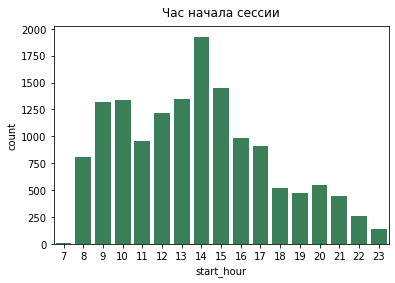

In [26]:
sns.countplot(x='start_hour', data=data_10users, color='seagreen')
plt.title('Час начала сессии', pad=10)
plt.show()

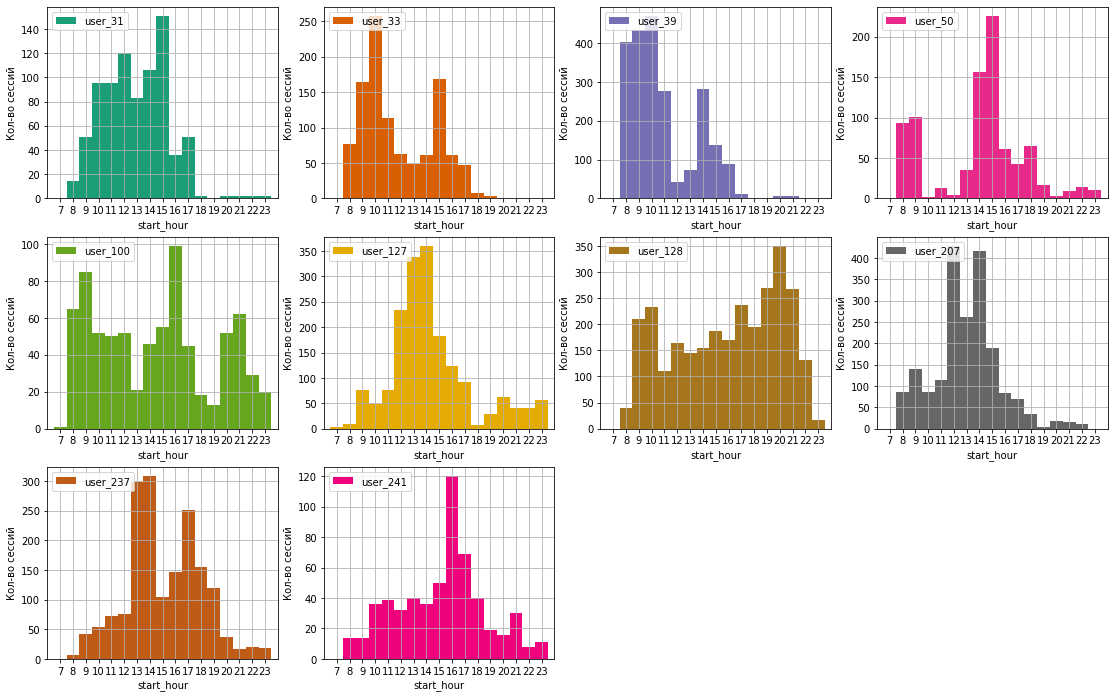

In [28]:
count_users(data_10users, 'start_hour', 'start_hour')

Видим, что распределения немного отличаются, кто-то вечером не заходит в сеть, у каждого есть часы с максимальной активностью.

Попробуем уменьшить количество значений

In [14]:
data_10users['binned_start_hour'] = pd.cut(data_10users.start_hour, bins=7)

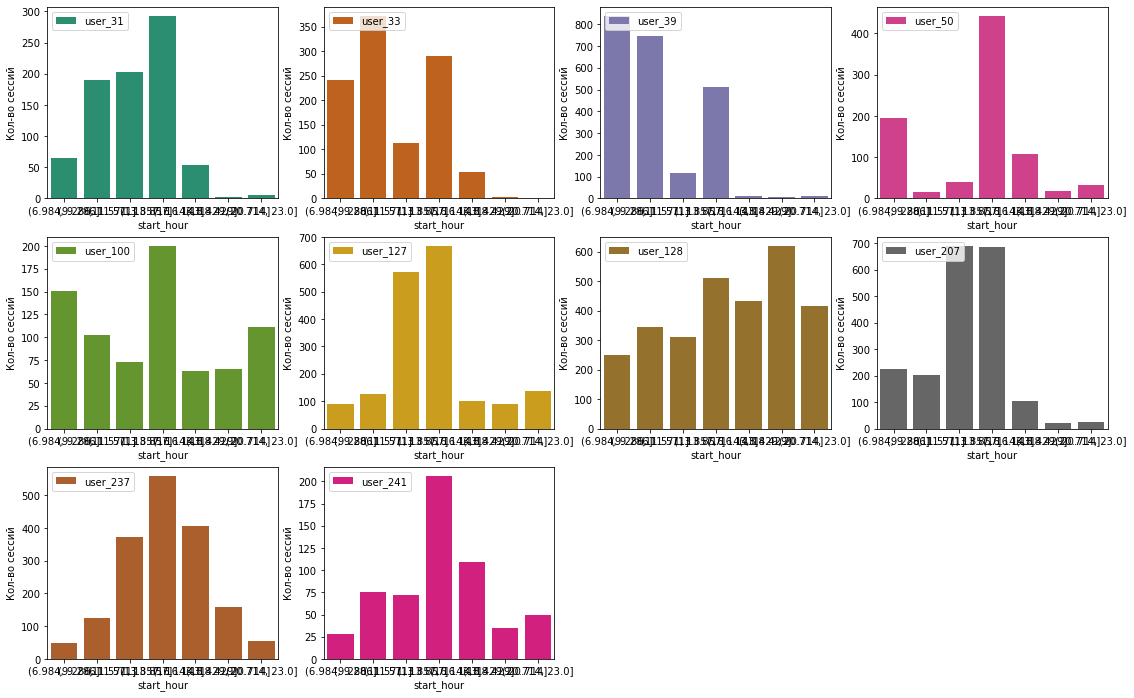

In [52]:
count_users(data_10users, 'binned_start_hour', 'start_hour', seab=True)

При bins=7 есть заметные отличия, но при этом число категорий меньше, что лучше скажется на качестве модели

#### day of week

In [46]:
xticks = ["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"]

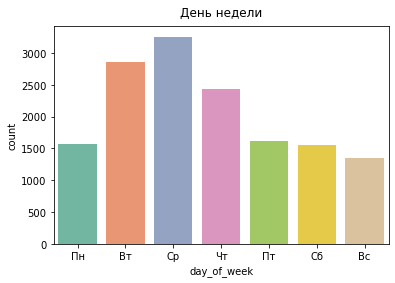

In [82]:
sns.countplot(x='day_of_week', data=data_10users, palette='Set2').set_xticklabels(xticks)
plt.title('День недели', pad=10)
plt.show()

В выборке присутствуют все дни недели

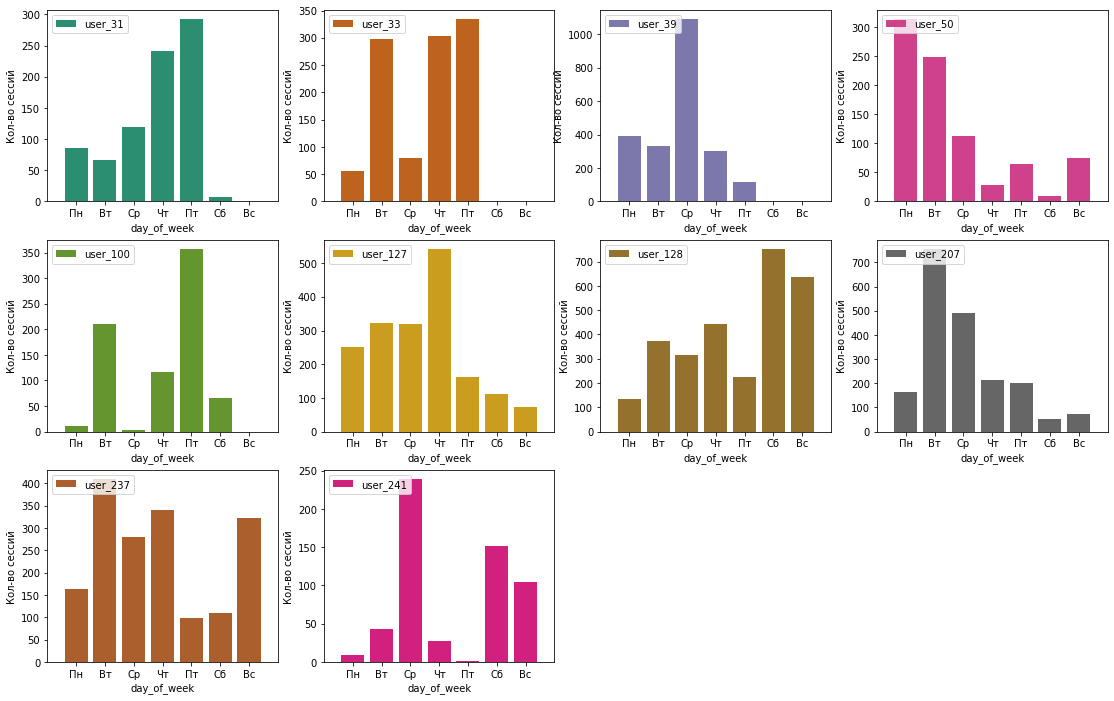

In [54]:
count_users(data_10users, 'day_of_week', 'day_of_week', xticks=xticks, seab=True)

Можно увидеть, что каждый день недели значимый и стоит оставить этот признак как есть

#### year, month

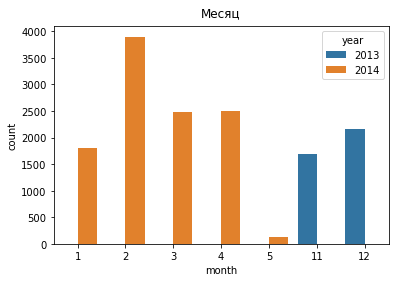

In [94]:
sns.countplot(x='month', hue='year', data=data_10users)
plt.title('Месяц', pad=10)
plt.show()

Из диаграммы видно, что данные получены всего за 7 месяцев. И эти два признака не будут информативны. Если бы данные были за 2 года и более, можно было бы взять признак **month**, учитывая тем самым годовую сезонность.

#### session_timespan

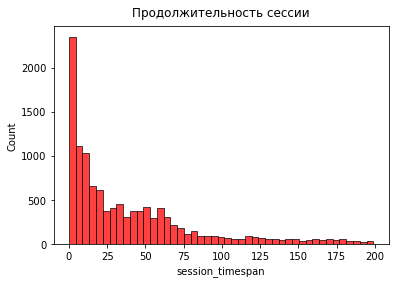

In [24]:
sns.histplot(x='session_timespan', data=data_10users[data_10users.session_timespan<200], color='red')
plt.title('Продолжительность сессии', pad=10)
plt.show()

In [127]:
data_10users[data_10users.session_timespan==0].shape

(83, 62)

In [13]:
data_10users[(data_10users.session_timespan<100) & (data_10users.session_timespan>1)].user_id.value_counts()

128    2347
39     1425
207    1352
127    1208
237    1067
33      734
31      530
100     476
50      462
241     281
Name: user_id, dtype: int64

Нулевых элементов всего 83.

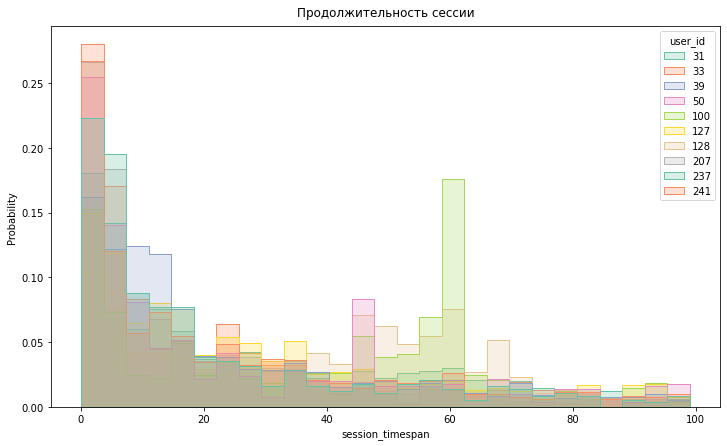

In [6]:
plt.figure(figsize=(12, 7))
sns.histplot(x='session_timespan', hue='user_id', 
             data=data_10users[data_10users.session_timespan<100], 
             palette='Set2', element='step', stat='probability', common_norm=False)
plt.title('Продолжительность сессии', pad=10)
plt.show()

Отличия пользователей проявляются в диапазоне от 0 до 100, скорее всего будем использовать его, введя дополнительный бинарный признак, а значения вне интервала заменив на значения из равномерного распределения. Также прологарифмируем признак. чтобы получить что-то близкое к нормальному распределению.

Сделаем Weight of Evidence encoding с тремя спосабами заполнения пропусков и посмотрим на гистограммы.

In [11]:
%%time
data_10users_1, woe_dicts_10users = woe_encoder(data_10users, 'session_timespan', 100, fill_method='zero')
data_10users_2, woe_dicts_10users = woe_encoder(data_10users, 'session_timespan', 100, fill_method='random')
data_10users_3, woe_dicts_10users = woe_encoder(data_10users, 'session_timespan', 100, fill_method='outlier')

<ipython-input-10-de562890d8d2>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column.isna()] = np.random.uniform(column.min(), column.max(), column.isna().sum())
<ipython-input-10-de562890d8d2>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[column.isna()] = np.random.uniform(column.min(), column.max(), column.isna().sum())
<ipython-input-10-de562890d8d2>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  column[colu

Wall time: 553 ms


In [11]:
data_10users_1.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10,...,woe_user128_session_timespan,woe_user33_session_timespan,woe_user100_session_timespan,woe_user39_session_timespan,woe_user237_session_timespan,woe_user207_session_timespan,woe_user241_session_timespan,woe_user50_session_timespan,woe_user127_session_timespan,woe_user31_session_timespan
session_id,,,,,,,,,,,,,,,,,,,,,
1,192,574,133,3,133,133,3,133,203,133,...,-0.039208,-0.130237,-0.326901,0.026171,0.049954,-0.093596,0.055566,-0.360641,0.420805,-0.184760
2,415,193,674,254,133,31,393,3305,217,55,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,55,3,55,55,5,293,415,333,897,55,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,473,3306,473,55,55,55,55,937,199,123,...,0.189313,0.051722,-0.512666,-0.226891,0.057439,0.188211,-0.040235,-0.841426,0.107309,-0.193234
5,342,55,5,3307,258,211,3308,2086,675,2086,...,-0.611478,-0.050827,-0.558291,-0.039338,0.136059,0.456320,0.314300,0.114889,-0.065116,0.470743


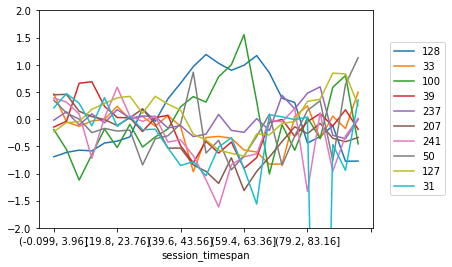

In [12]:
# посмотрим как каждый диапазон session_timespan влияет на вероятность отнесения объекта к i-му классу
for i, user_id in enumerate(set(data_10users.user_id)):
    woe_dicts_10users[i].plot(label=user_id)
plt.ylim(-2, 2)
plt.legend(loc=(1.05, 0.15))
plt.show()

Для каждого из классов есть отклонения от нуля, нельзя сказать, что по этому признаку можно отделить каждый класс, но как минимум сгруппировать можно.

In [12]:
def move_legend(ax, new_loc, **kws):
    '''Функция, которая сдвигает легенду за пределы фрейма'''
    old_legend = ax.legend_
    handles = old_legend.legendHandles
    labels = [t.get_text() for t in old_legend.get_texts()]
    title = old_legend.get_title().get_text()
    ax.legend(handles, labels, loc=new_loc, title=title, **kws)

In [15]:
def hist_woe(data, origin_feature):
    '''Функция, которая строит гистограммы woe-признаков, полученных из origin_feature'''
    fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(19, 15))
    axes = axes.ravel()
    users = list(set(data.user_id))
    for idx, user_id in enumerate(users[:-1]):
        feature = 'woe_user'+str(user_id)+'_'+origin_feature
        sns.histplot(x=feature, hue='user_id', 
             data=data[data[feature]>-3], ax=axes[idx], bins=25, legend=False,
             palette='Set2', element='step', stat='probability', common_norm=False)
        
    idx += 1
    hist = sns.histplot(x='woe_user'+str(users[-1])+'_'+origin_feature, hue='user_id', 
             data=data[data['woe_user'+str(users[-1])+'_'+origin_feature]>-3], ax=axes[idx], bins=25,
             palette='Set2', element='step', stat='probability', common_norm=False)
    move_legend(axes[idx], (1.1, 0.2))
    for i in range(idx+1, axes.shape[0]):
        axes[i].remove()
    plt.show()

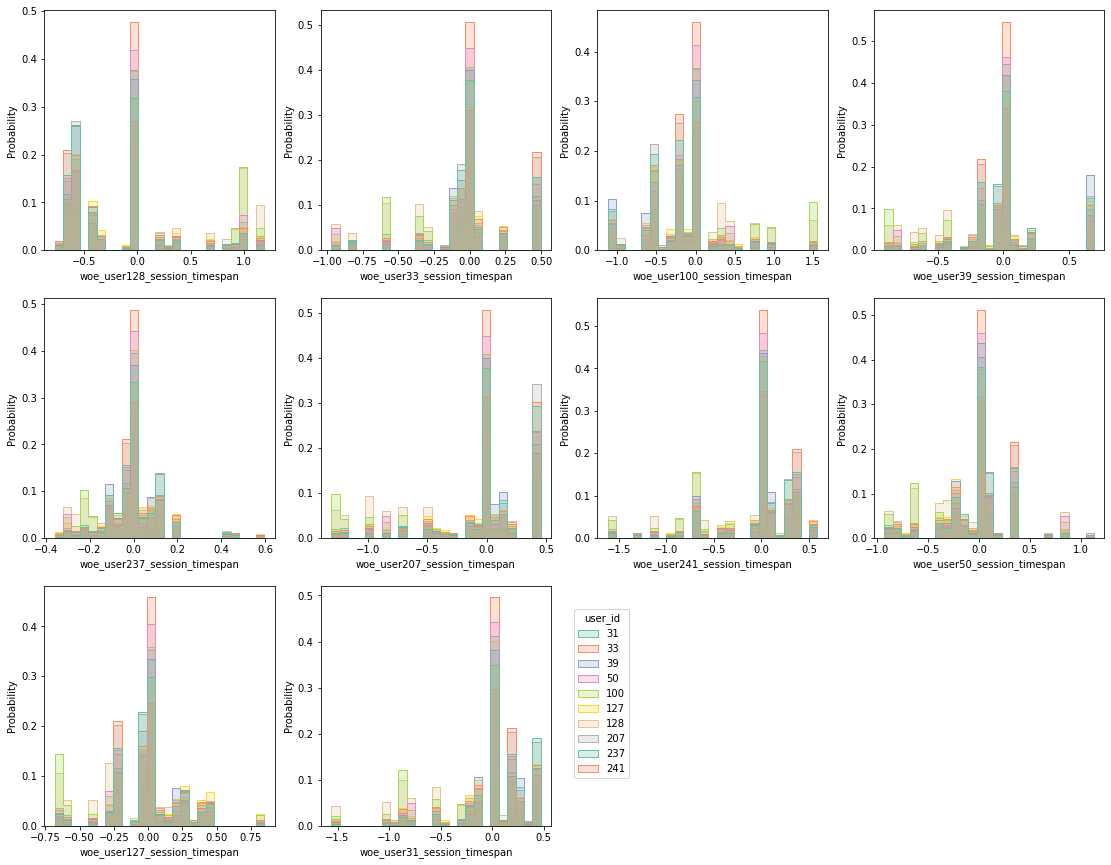

In [16]:
hist_woe(data_10users_1, 'session_timespan')

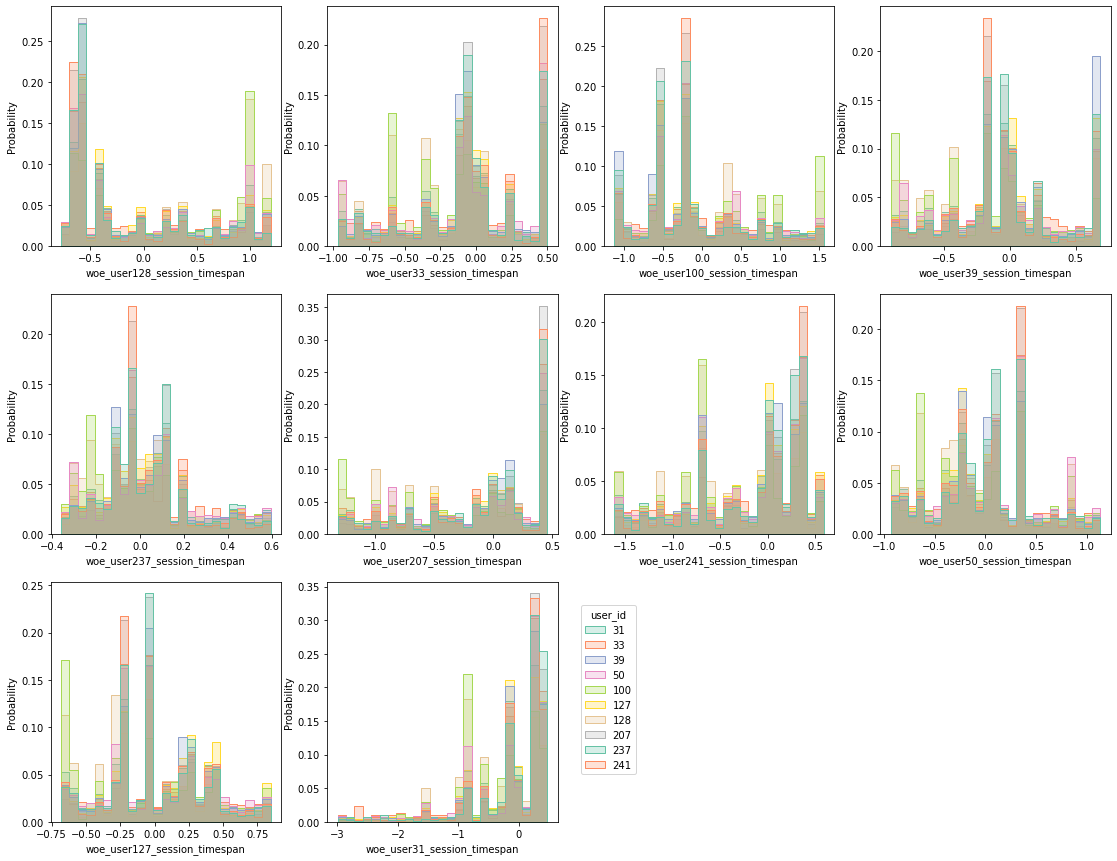

In [17]:
hist_woe(data_10users_2, 'session_timespan')

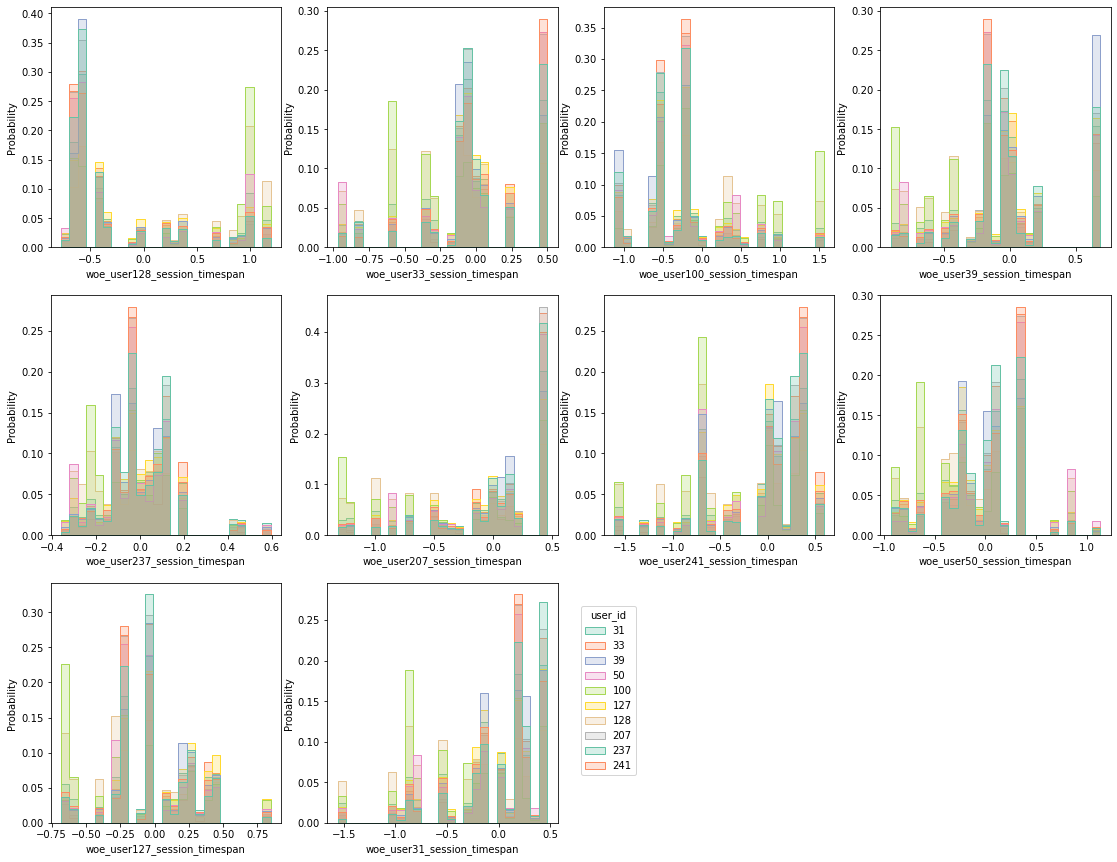

In [18]:
hist_woe(data_10users_3, 'session_timespan')

Как видно из графиков, классы сильно перемешаны, но некоторые из них можно выделить. Самый простой способ при обучении попоробовать все три способа заполнения пропусков, а сами признаки отобрать через понижение размерности. Когда мы будем брать 150 пользователей или 3000, то соответсвенно увеличится и количество классов и этих признаков, что будет приводить к переобучению, поэтому отбор признаков обязателен. В соревновании Catch Me будет всего один признак, его можно будет отдельно рассмотреть и решить, несет ли он какую либо информацию.

#### top_sites_time

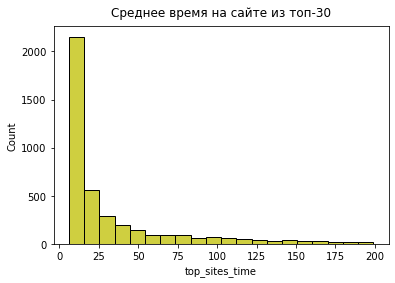

In [55]:
sns.histplot(x='top_sites_time', data=data_10users[(data_10users.top_sites_time>5)&\
                                                   (data_10users.top_sites_time<200)], color='y', bins=20)
plt.title('Среднее время на сайте из топ-30', pad=10)
plt.show()

In [40]:
data_10users[data_10users.top_sites_time==0].shape

(5829, 62)

Достаточно много нулевых значений признака из-за того, что есть без сайтов из топ-30. Так как у нас есть еще бинарные признаки **is_top**, то делать ничего не нужно, эти признаки как раз будут уменьшать значимость нуля в **top_sites_time**.

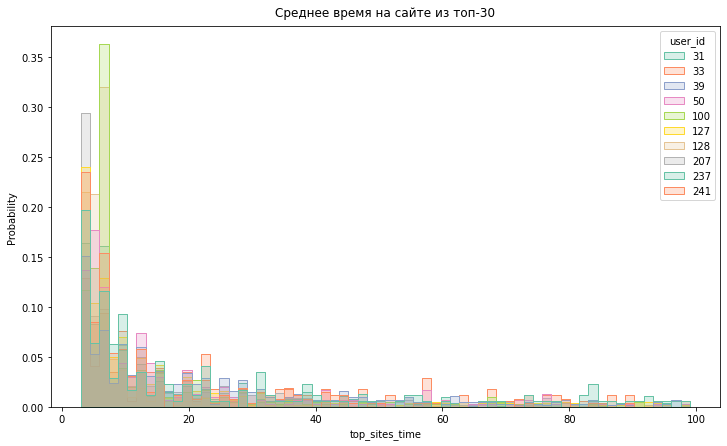

In [47]:
plt.figure(figsize=(12, 7))
sns.histplot(x='top_sites_time', hue='user_id', 
             data=data_10users[(data_10users.top_sites_time>2)&(data_10users.top_sites_time<100)], 
             palette='Set2', element='step', stat='probability', common_norm=False)
plt.title('Среднее время на сайте из топ-30', pad=10)
plt.show()

Значимых отличий между классами нет. Попробуем сделать woe-encoding.

In [48]:
data_10users_4, woe_dicts_10users = woe_encoder(data_10users, 'top_sites_time', 100, fill_method='outlier')

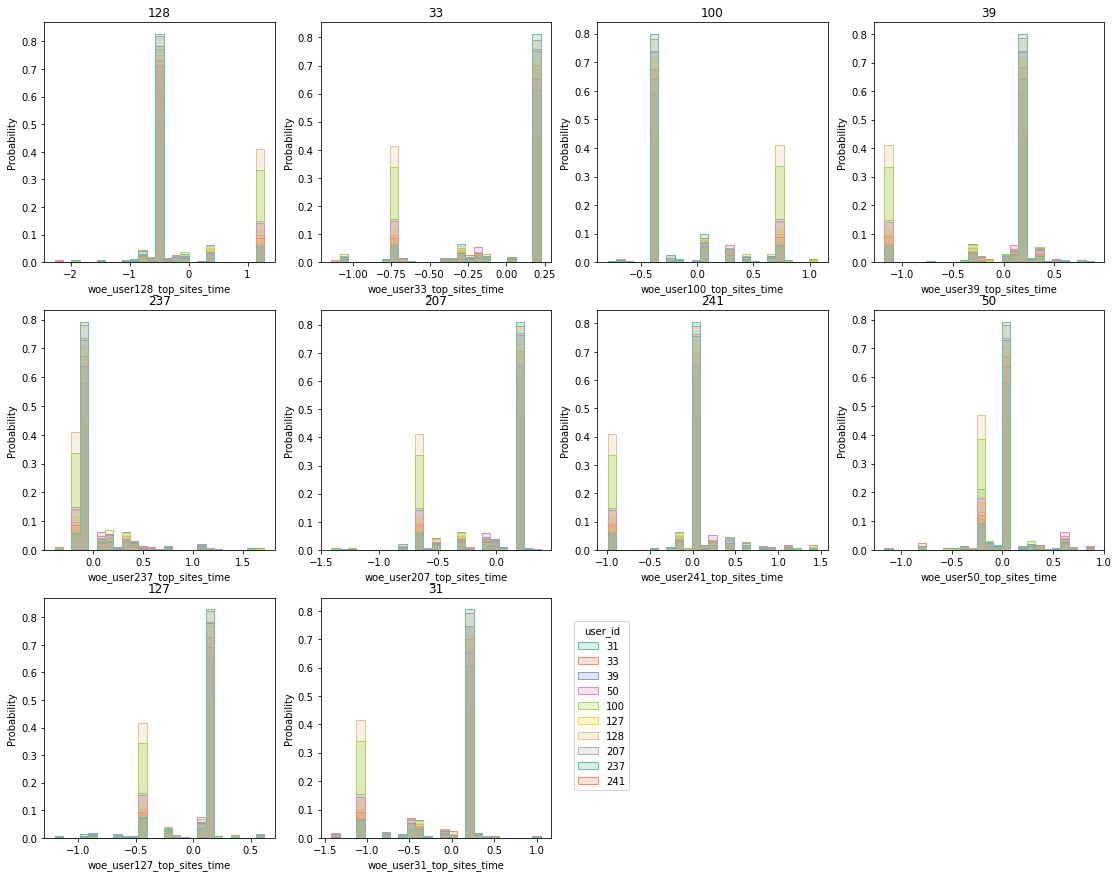

In [53]:
hist_woe(data_10users_4, 'top_sites_time')

Признак **top_sites_time** получается неинформативный, не будем его использовать.

#### unique_sites

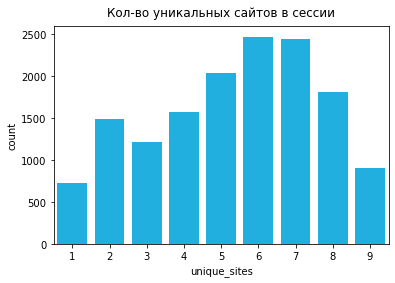

In [72]:
sns.countplot(x='unique_sites', data=data_10users, color='deepskyblue')
plt.title('Кол-во уникальных сайтов в сессии', pad=10)
plt.show()

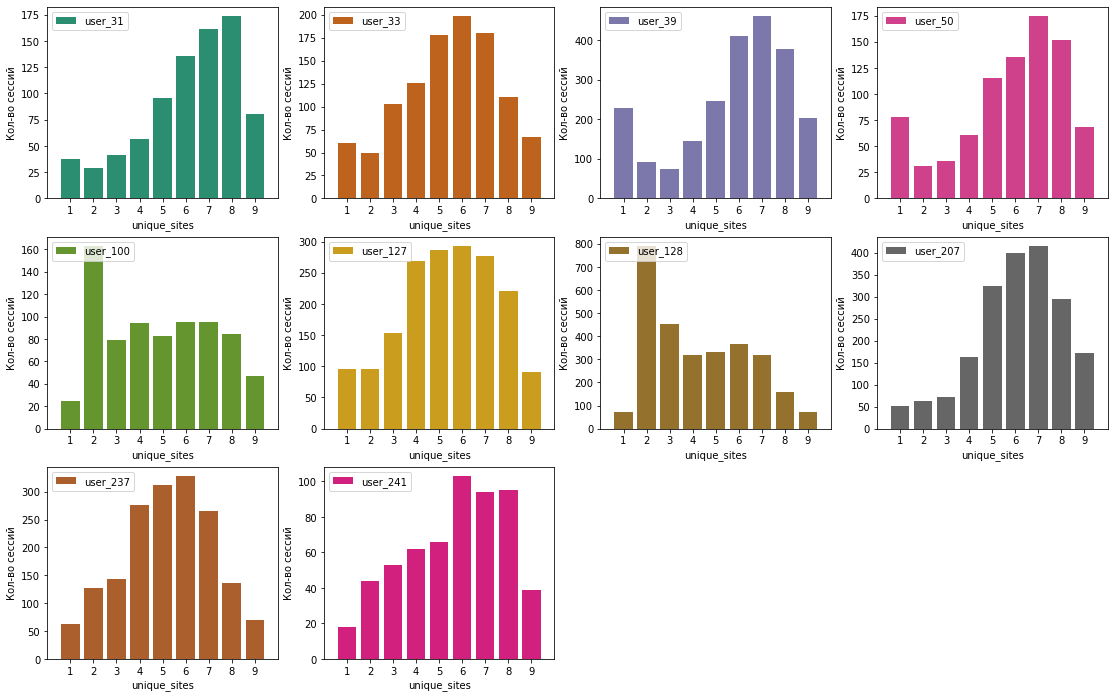

In [57]:
count_users(data_10users, 'unique_sites', 'unique_sites', xlims=(0, 8), seab=True)

У некоторых пользователей есть выделяющийся пик в 1 и 2, сделаем дополнительные бинарные признаки, описывающие это свойство.

In [15]:
data_10users['unique_site_1'] = [1 if x==1 else 0 for x in data_10users['unique_sites']]
data_10users['unique_site_2'] = [1 if x==2 else 0 for x in data_10users['unique_sites']]

#### facebook_freq

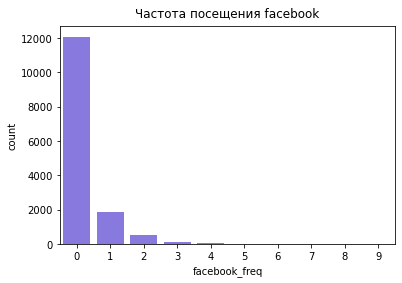

In [39]:
sns.countplot(x='facebook_freq', data=data_10users, color='mediumslateblue')
plt.title('Частота посещения facebook', pad=10)
plt.show()

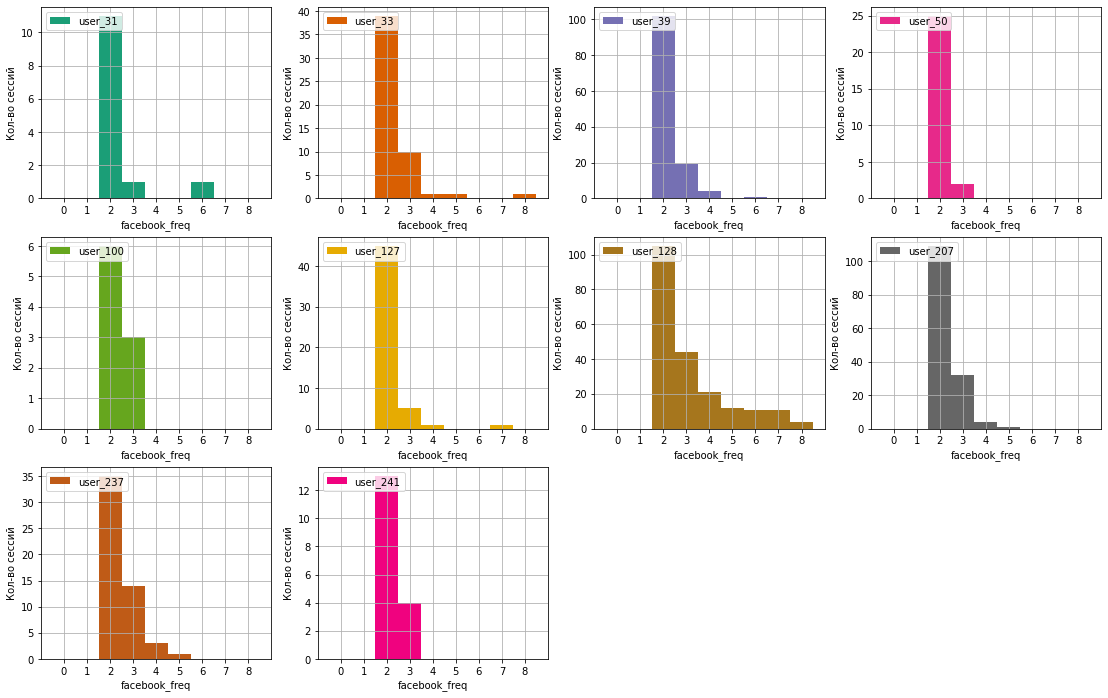

In [58]:
count_users(data_10users[data_10users['facebook_freq']>1], 'facebook_freq', 'facebook_freq', xlims=(0, 8))

Если убрать значения признака 0 и 1, то видны различия в хвостах распределений. Чтобы убрать 0 и 1, сделаем бинарный признак который принимает 1, когда **facebook_freq** принимает эти значения.

In [16]:
data_10users['facebook_flag'] = data_10users['facebook_freq'].apply(lambda x: 1 if x in [0, 1] else 0)

#### is_top_i

Бинарные признаки, показывающие наличие сайта из топ-30 в сессии

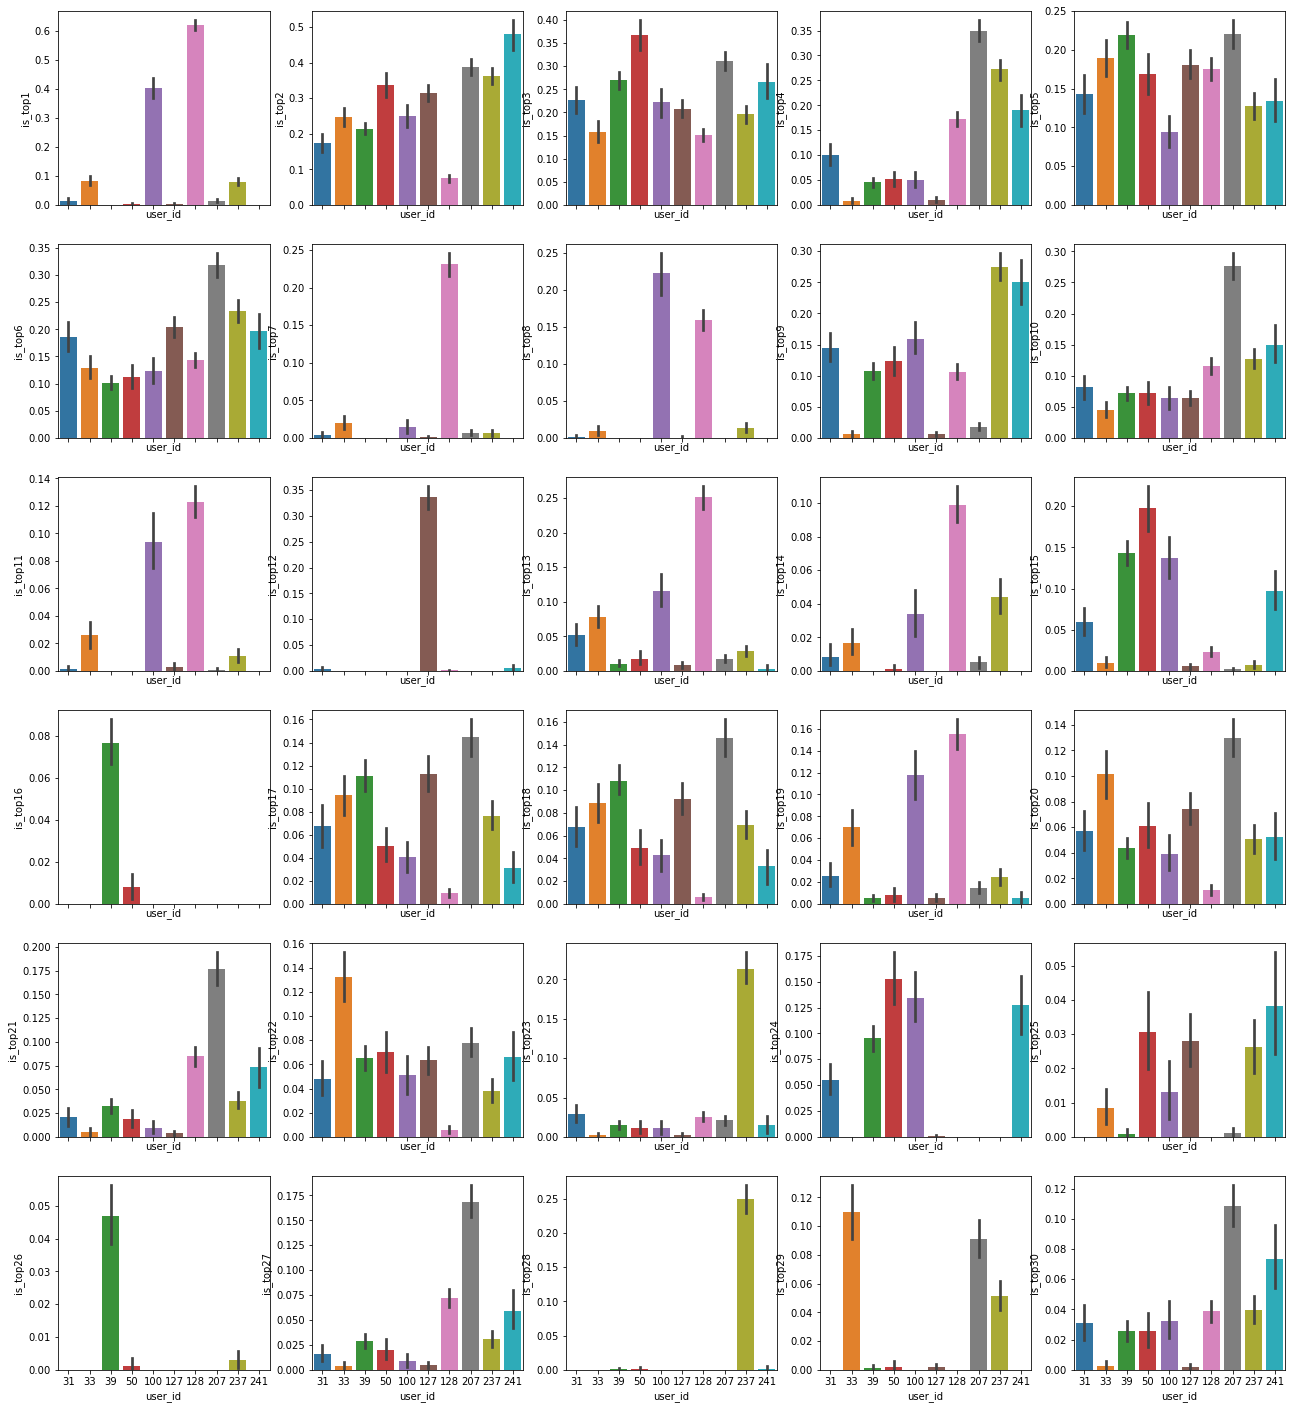

In [28]:
_, axes = plt.subplots(nrows=6, ncols=5, figsize=(22, 25), sharex=True)
axes = axes.ravel()
for i in range(1, 31):
    sns.barplot(x='user_id', y='is_top'+str(i), data=data_10users, ax=axes[i-1])

Видно, что многие признаки хорошо отделяют отдельные классы, поэтому их точно нужно использовать.

#### day of month

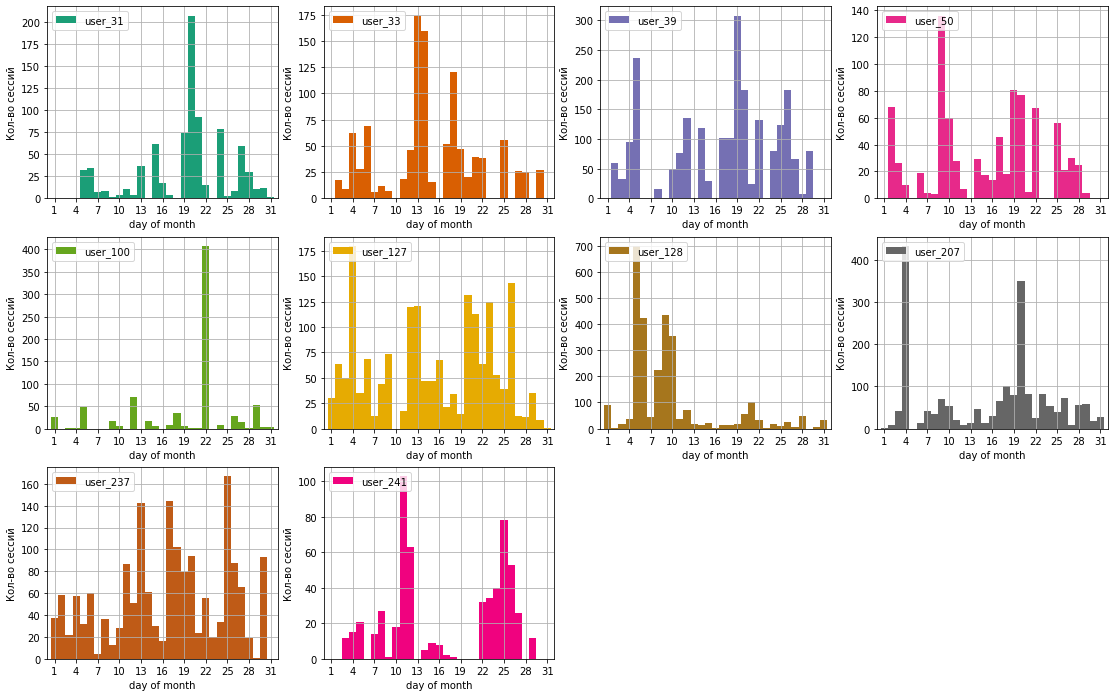

In [60]:
count_users(data_10users, 'day', 'day of month', ticks_delta=3)

Пользователи хорошо различаются по данному признаку.

## Save features

In [18]:
data_10users.to_csv(os.path.join(PATH_TO_EXPS, 'train_data_10users_for_catch_me_ready.csv'))

### 150 Users

In [3]:
data_150users = pd.read_csv(os.path.join(PATH_TO_EXPS, 'train_data_150users_for_catch_me.csv'), 
                            index_col=0)

In [4]:
features_150users = pd.read_csv(os.path.join(PATH_TO_EXPS, 'new_features_150users_for_catch_me.csv'), 
                               index_col=0)

In [6]:
data_150users = pd.concat((data_150users, features_150users), axis=1)

In [7]:
data_150users['binned_start_hour'] = pd.cut(data_150users.start_hour, bins=7)

In [8]:
data_150users['unique_site_1'] = [1 if x==1 else 0 for x in data_150users['unique_sites']]
data_150users['unique_site_2'] = [1 if x==2 else 0 for x in data_150users['unique_sites']]

In [9]:
data_150users['facebook_flag'] = data_150users['facebook_freq'].apply(lambda x: 1 if x in [0, 1] else 0)

In [10]:
data_150users.to_csv(os.path.join(PATH_TO_EXPS, 'train_data_150users_for_catch_me_ready.csv'))